# Modeling

## 1. SARIMA

In [1]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn import datasets, linear_model
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
import tensorflow as tf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
plt.style.use('seaborn-deep')
import warnings
warnings.filterwarnings("ignore")

In [2]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

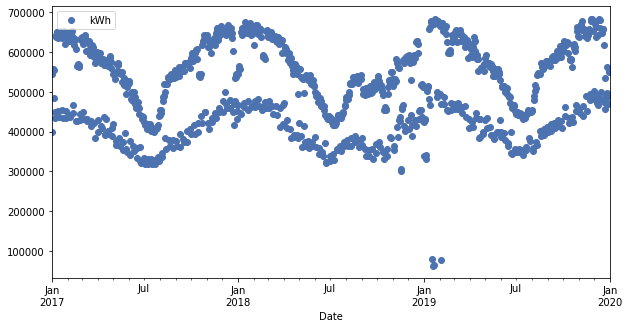

In [3]:
ts.plot(figsize=(10,5),style="o")

In [4]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=14, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -2.519272
p-value                           0.110855
#Lags Used                       14.000000
Number of Observations Used    1081.000000
Critical Value (1%)              -3.436414
Critical Value (5%)              -2.864217
Critical Value (10%)             -2.568196
dtype: float64


<AxesSubplot:xlabel='Date'>

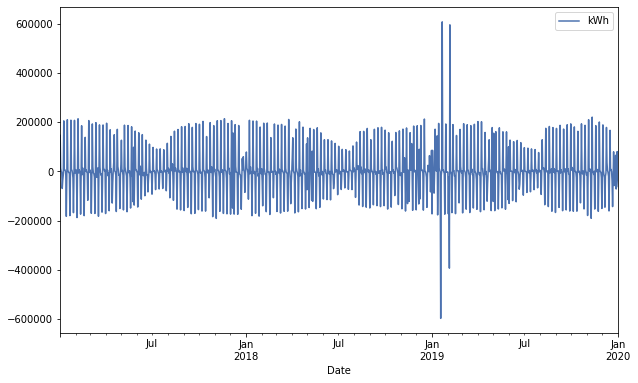

In [5]:
# invert differenced forecast
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

diffed = diff(ts,seasonal_periods=7)
diffed.plot(figsize=(10,6))

In [6]:
test_stationarity(diffed.kWh)

Results of Dickey-Fuller Test:
Test Statistic                -1.287184e+01
p-value                        4.860589e-24
#Lags Used                     1.400000e+01
Number of Observations Used    1.080000e+03
Critical Value (1%)           -3.436419e+00
Critical Value (5%)           -2.864220e+00
Critical Value (10%)          -2.568197e+00
dtype: float64


<AxesSubplot:xlabel='Date'>

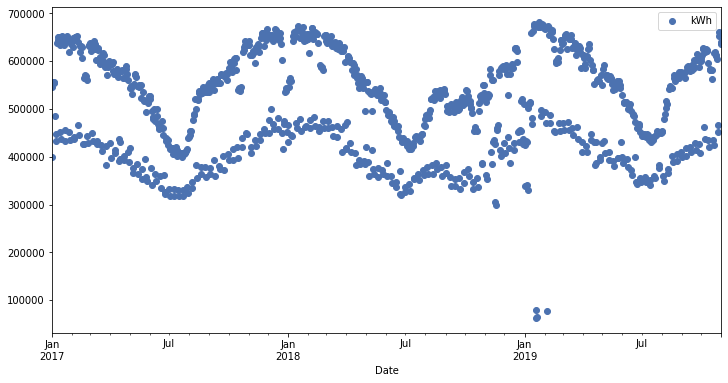

In [7]:
train_end = '2019-11-01'
test_end = '2019-12-01'
demo_start = '2019-10-25'
demo = ts[demo_start:test_end]
train,test,validation = ts[:train_end],\
                        ts[train_end:test_end],\
                        ts[test_end:]

train.plot(figsize=(12,6), style = 'o')

There is complex seasonality in play

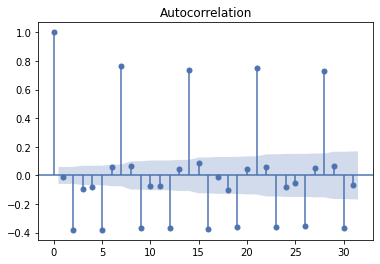

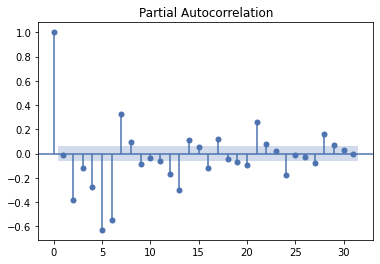

In [8]:
acf = plot_acf(diffed)
pacf = plot_pacf(diffed)

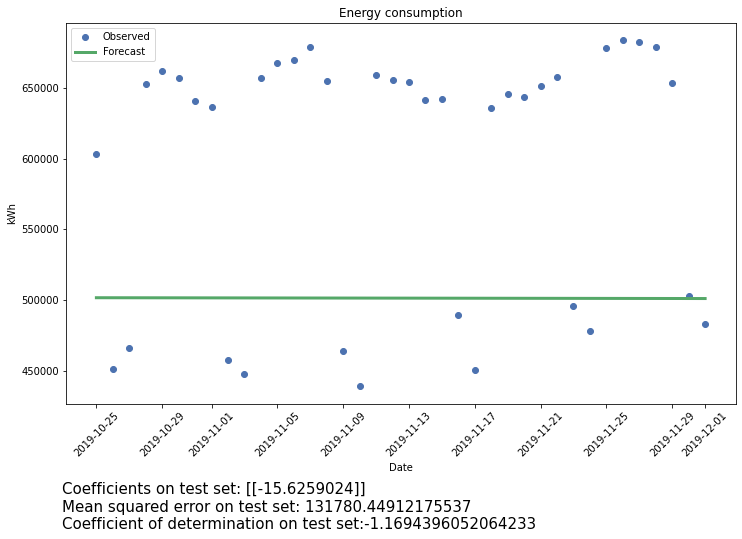

In [9]:
from math import sqrt

X = (train.index - train.index[0]).days.values.reshape(-1, 1)
y = train.kWh.values.reshape(-1, 1)

X_demo = (demo.index - train.index[0]).days.values.reshape(-1,1)
y_demo = demo.kWh.values.reshape(-1, 1)

X_test = (test.index - train.index[0]).days.values.reshape(-1,1)
y_test = test.kWh.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X,y)

regr_pred_demo = regr.predict(X_demo)
regr_pred_test = regr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', xlabel='Date', ylabel='kWh')

ax.plot(demo.index, y_demo,'o')
ax.plot(demo.index, regr_pred_demo, linewidth=3)

err = 'Coefficients on test set: ' + str(regr.coef_) + '\nMean squared error on test set: ' + \
    str(sqrt(MSE(y_test, regr_pred_test))) + '\nCoefficient of determination on test set:' + \
        str(r2_score(y_test, regr_pred_test))

plt.figtext(0.12, -0.08, err, ha="left",fontsize=15,va='center')
plt.xticks(rotation=45)
legend = ax.legend(["Observed", "Forecast"])




## Grid Search

In [10]:
def sarimax(ts,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMA{}x{}7 - AIC:{}'.format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
            
    return results

In [11]:
# set parameter range
p,d,q = range(0,2),[1],range(0,2)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

start = time.perf_counter()
all_res = sarimax(train,all_param)
finish = time.perf_counter()

Tried out SARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:25637.314706991765
Tried out SARIMA(0, 1, 0)x(0, 1, 1, 7)7 - AIC:25100.086577215647
Tried out SARIMA(0, 1, 0)x(0, 1, 2, 7)7 - AIC:25096.42101429862
Tried out SARIMA(0, 1, 0)x(1, 1, 0, 7)7 - AIC:25417.302961958805
Tried out SARIMA(0, 1, 0)x(1, 1, 1, 7)7 - AIC:25089.015766582146
Tried out SARIMA(0, 1, 0)x(1, 1, 2, 7)7 - AIC:25074.092476446647
Tried out SARIMA(0, 1, 0)x(2, 1, 0, 7)7 - AIC:25284.541220138744
Tried out SARIMA(0, 1, 0)x(2, 1, 1, 7)7 - AIC:25071.665698711506
Tried out SARIMA(0, 1, 0)x(2, 1, 2, 7)7 - AIC:25068.58649505663
Tried out SARIMA(0, 1, 1)x(0, 1, 0, 7)7 - AIC:25505.09240877111
Tried out SARIMA(0, 1, 1)x(0, 1, 1, 7)7 - AIC:25093.753851571724
Tried out SARIMA(0, 1, 1)x(0, 1, 2, 7)7 - AIC:25086.89353095259
Tried out SARIMA(0, 1, 1)x(1, 1, 0, 7)7 - AIC:25303.508546662637
Tried out SARIMA(0, 1, 1)x(1, 1, 1, 7)7 - AIC:25087.037846115174
Tried out SARIMA(0, 1, 1)x(1, 1, 2, 7)7 - AIC:25088.887622619983
Tried out SARIMA(0, 1, 1)x(2,

In [12]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f5477198b0>,
  25060.50091060186,
  ((1, 1, 1), (0, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f54c17d280>,
  25060.657293727145,
  ((1, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f54c17d310>,
  25062.439962177774,
  ((1, 1, 1), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f55c7e6040>,
  25062.51273679213,
  ((1, 1, 1), (2, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f55c806790>,
  25064.314057435855,
  ((1, 1, 1), (2, 1, 2, 7)))]

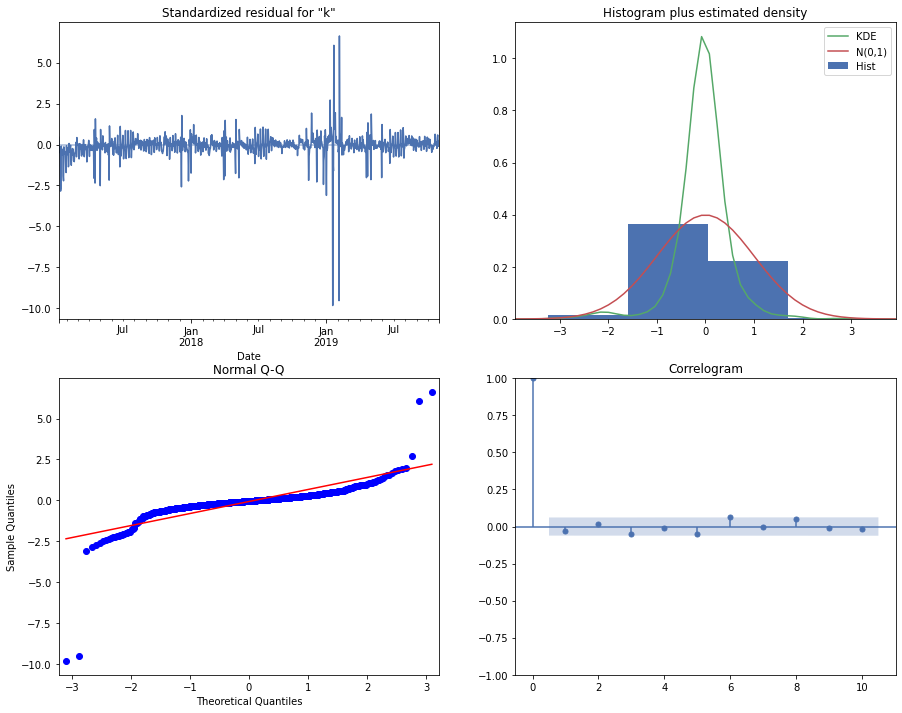

Ljung-box p-values:
[0.32732125 0.547594   0.25772835 0.38557225 0.25649477 0.10349745
 0.15867916 0.10184861 0.14683038 0.19192535 0.25470829 0.32558795
 0.40096047 0.41503449]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kWh   No. Observations:                 1035
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12525.329
Date:                           Thu, 07 Jan 2021   AIC                          25060.657
Time:                                   20:30:11   BIC                          25085.329
Sample:                               01-01-2017   HQIC                         25070.022
                                    - 11-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4686      0.043     10.870      0.000       0.384       0.553
ma.L1         -0.8065      0.040    -19.988      0.000      -0.886      -0.727
ar.S.L7        0.1057      0.032      3.271      0.001       0.042       0.169
ma.S.L7       -0.9838      0.022    -43.848      0.000      -1.028      -0.940
sigma2      3.554e+09   7.46e-12   4.77e+20      0.000    3.55e+09    3.55e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):            203079.56
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -3.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.77e+35. Standard errors may be unstable.
"""

In [14]:
res = all_res[1][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

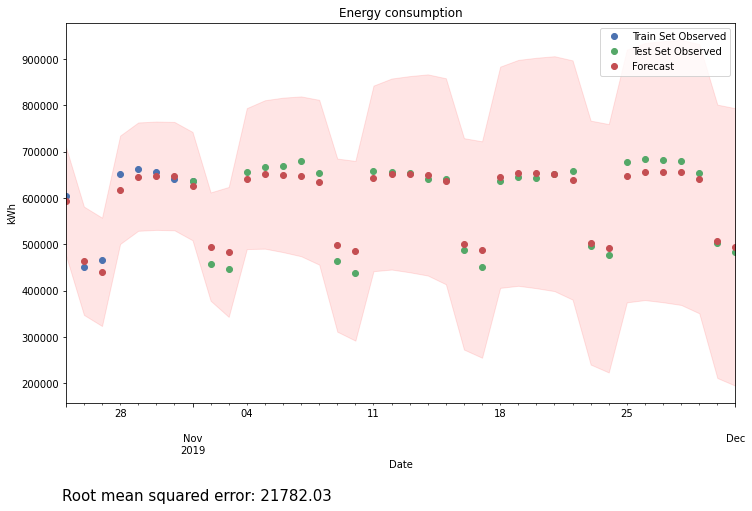

In [15]:
""" For demo only """
pred_test = res.get_prediction(start=train_end,end=test_end)

# The mean squared error
err = 'Root mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax, style='o')
test.plot(ax=ax, style='o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

# LSTM

## Feature Engineering

In [16]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

NameError: name 'date_time' is not defined

In [ ]:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [18]:
date = ts.index
date.map(datetime.datetime.timestamp)

Float64Index([1483221600.0, 1483308000.0, 1483394400.0, 1483480800.0,
              1483567200.0, 1483653600.0, 1483740000.0, 1483826400.0,
              1483912800.0, 1483999200.0,
              ...
              1577052000.0, 1577138400.0, 1577224800.0, 1577311200.0,
              1577397600.0, 1577484000.0, 1577570400.0, 1577656800.0,
              1577743200.0, 1577829600.0],
             dtype='float64', name='Date', length=1096)